In [1]:
%matplotlib inline
import sys
sys.path.append("../../../agnpy")
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from agnpy.particles import Blob
from astropy.coordinates import Distance
from agnpy.synchrotron import Synchrotron
from agnpy.compton import Compton

In [2]:
MEC2 = (const.m_e * const.c * const.c).cgs.value
H = const.h.cgs.value

In [3]:
spectrum_norm = 1e48 * u.Unit("erg")
parameters = {"p": 2.8, "gamma_min": 1e2, "gamma_max": 1e5}
spectrum_dict = {"type": "PowerLaw", "parameters": parameters}
R_b = 1e16 * u.cm
B = 1 * u.G
z = Distance(1e27, unit=u.cm).z
delta_D = 10
Gamma = 10
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

normalizing power-law to total energy density u_e: 2.39e-01 erg cm-3


In [4]:
nu = np.logspace(8, 30, 100) * u.Hz

synchrotron = Synchrotron(blob)
# flux SED
sed_synch = synchrotron.sed_flux(nu, SSA=True)
sed_ssc = synchrotron.ssc_sed_flux(nu)

../../../agnpy/agnpy/synchrotron.py:116: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
../../../agnpy/agnpy/synchrotron.py:116: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
../../../agnpy/agnpy/compton.py:20: RuntimeWarning: invalid value encountered in log
  term_1 = 2 * q * np.log(q)


# check Synchrotron Self Absorption

In [5]:
epsilon = H * nu.to("Hz").value / MEC2
# correct epsilon to the comoving frame
epsilon *= (1 + blob.z) / blob.delta_D
tau = synchrotron.tau_SSA(epsilon)
attenuation = synchrotron.attenuation_SSA(epsilon)

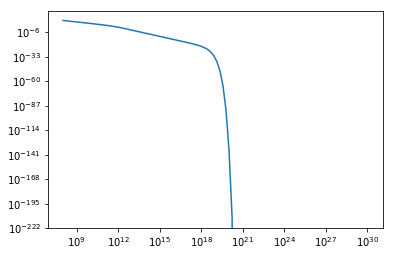

In [6]:
plt.loglog(nu, tau)

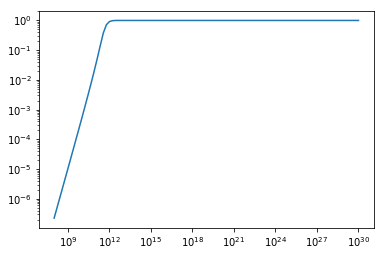

In [7]:
plt.loglog(nu, attenuation)

# JetSet comparison

In [8]:
from jetset.jet_model import Jet
jet = Jet(name='test',electron_distribution='pl',)
jet.show_pars()

-------------------------------------------------------------------------------------------------------------------
model parameters:
 Name             | Type                 | Units            | value         | phys. boundaries              | log
-------------------------------------------------------------------------------------------------------------------
 B                | magnetic_field       | G                | +1.000000e-01 | [+0.000000e+00,No           ] | False 
 N                | electron_density     | cm^-3            | +1.000000e+02 | [+0.000000e+00,No           ] | False 
 R                | region_size          | cm               | +1.569897e+01 | [+0.000000e+00,+3.000000e+01] | True 
 beam_obj         | beaming              |                  | +1.000000e+01 | [+1.000000e+00,No           ] | False 
 gmax             | high-energy-cut-off  | Lorentz-factor   | +1.000000e+06 | [+1.000000e+00,+1.000000e+15] | False 
 gmin             | low-energy-cut-off   | Lorentz-f

In [9]:
jet.set_par('B',val=blob.B)
jet.set_par('N',val=blob.norm.value)
jet.set_par('R',val=np.log10(blob.R_b))
jet.set_par('beam_obj',val=blob.delta_D)
jet.set_par('gmin',val=blob.gamma_min)
jet.set_par('gmax',val=blob.gamma_max)
jet.set_par('p',val=blob.n_e.p)
jet.set_par('z_cosm',val=blob.z)
# swictch off synchrotron self absorption
jet.set_gamma_grid_size(1000)
jet.nu_seed_size = 1000
jet.show_pars()

-------------------------------------------------------------------------------------------------------------------
model parameters:
 Name             | Type                 | Units            | value         | phys. boundaries              | log
-------------------------------------------------------------------------------------------------------------------
 B                | magnetic_field       | G                | +1.000000e+00 | [+0.000000e+00,No           ] | False 
 N                | electron_density     | cm^-3            | +1.302546e+03 | [+0.000000e+00,No           ] | False 
 R                | region_size          | cm               | +1.600000e+01 | [+0.000000e+00,+3.000000e+01] | True 
 beam_obj         | beaming              |                  | +1.000000e+01 | [+1.000000e+00,No           ] | False 
 gmax             | high-energy-cut-off  | Lorentz-factor   | +1.000000e+05 | [+1.000000e+00,+1.000000e+15] | False 
 gmin             | low-energy-cut-off   | Lorentz-f

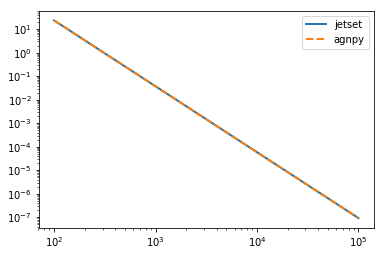

total density 1.30e+03 1 / cm3
total energy 1.00e+48 erg


In [10]:
# check the input electron density
plt.loglog(jet.electron_distribution.gamma, jet.electron_distribution.n_gamma, lw=2, label="jetset")
plt.loglog(blob.gamma, blob.n_e(blob.gamma), lw=2, ls="--", label="agnpy")
plt.legend()
plt.show()
print(f"total density {blob.norm:.2e}")
print(f"total energy {blob.W_e:.2e}")

In [11]:
jet.eval()
x, y = jet.get_SED_points()

Text(0, 0.5, '$\\nu F_{\\nu} / (erg\\,cm^{-2}\\,s^{-1})$')

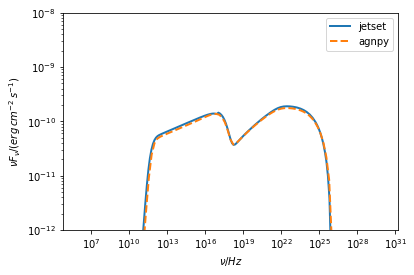

In [12]:
plt.loglog(x, y, lw=2, label="jetset")
plt.loglog(nu, sed_synch + sed_ssc, lw=2, ls="--", label="agnpy")
plt.legend()
plt.ylim([1e-12, 1e-8])
plt.xlabel(r"$\nu / Hz$")
plt.ylabel(r"$\nu F_{\nu} / (erg\,cm^{-2}\,s^{-1})$")